In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sympy as sym

In [2]:
import sympy as sym

x, y, z, t = sym.symbols('x y z t', real=True)
x_1, px_1, y_1, py_1 = sym.symbols('x_{1} p_{x} y_{1} p_{y}', real=True)
beta_x1, beta_y1 = sym.symbols('\\beta_{x1} \\beta_{y1}', real=True)
epsilon_n_x1, epsilon_n_y1 = sym.symbols('\\epsilon_{n_{x1}} \\epsilon_{n_{y1}}', real=True)

sigmaz, beta1, gamma,  beta2, c, N1, N2, f, nb, N, sigma_inel = sym.symbols(
    '\\sigma_{z} \\beta_{r1} \\gamma_{r} '
    ' \\beta_{r2} '
    'c N_1 N_2 f_{r} n_{b} N \sigma_{inel}', positive=True)

sigmax, sigmay = sym.symbols('''
\sigma_{x} \sigma_{y}''', positive=True)

def rho(x, mux, sigmax):
    return 1 / (sym.sqrt(2 * sym.pi) * sigmax) * sym.exp(-(x - mux) ** 2 / (2 * sigmax ** 2))

# Mean value computations
mux1 = x_1 + px_1 * z
mux2 = -x_1 - px_1 * z
muy1 = y_1 + py_1 * z
muy2 = -y_1 - py_1 * z


x_factor=sym.integrate(rho(x, mux1, sigmax)*rho(x, mux2, sigmax), (x, -sym.oo , sym.oo))
x_factor=x_factor
y_factor=sym.integrate(rho(y, muy1, sigmay)*rho(y, muy2, sigmay), (y, -sym.oo , sym.oo))
y_factor=y_factor
t_factor=sym.integrate(rho(z, t, sigmaz)*rho(z, -t, sigmaz), (t, -sym.oo , sym.oo))
t_factor=t_factor
Lz_t = N**2*nb*f*2*(x_factor*y_factor*t_factor).simplify().simplify()
Lz = N**2*nb*f*2*(x_factor*y_factor).simplify().simplify()

In [3]:
pile_up_density = sigma_inel/(nb*f) *Lz_t
pile_up_density 

N**2*\sigma_{inel}*exp(-(\sigma_{x}**2*\sigma_{y}**2*z**2 + \sigma_{x}**2*\sigma_{z}**2*(p_{y}**2*z**2 + 2*p_{y}*y_{1}*z + y_{1}**2) + \sigma_{y}**2*\sigma_{z}**2*(p_{x}**2*z**2 + 2*p_{x}*x_{1}*z + x_{1}**2))/(\sigma_{x}**2*\sigma_{y}**2*\sigma_{z}**2))/(4*pi**(3/2)*\sigma_{x}*\sigma_{y}*\sigma_{z})

Crossing plane (deg):  51.546
Separation plane (deg):  112.766
Angle between crossing and separation (deg) 61.220000000000006


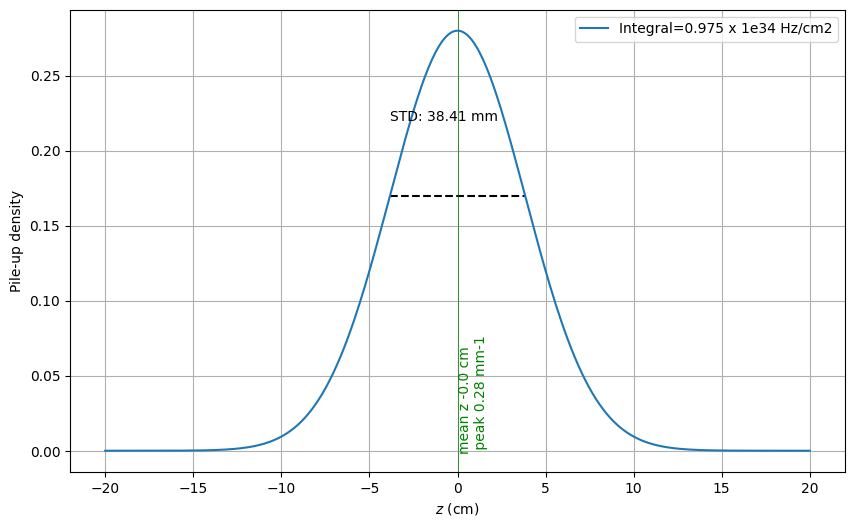

In [7]:
frev = 11245.5
nb = 2574
sigmainel = 8.0e-30
betx = 0.5
bety = 1.5
xing_x = 135
xing_y = 170

theta_crossing = np.arctan(170/135)
print("Crossing plane (deg): ", round(np.rad2deg(theta_crossing),3))

separation_plane = theta_crossing + np.deg2rad(61.22) # np.pi/2.
print("Separation plane (deg): ", round(np.rad2deg(separation_plane),3))
print("Angle between crossing and separation (deg)", round(np.rad2deg(separation_plane),3) - round(np.rad2deg(theta_crossing),3))

total_separation = 2e-5

num_values = {
    x_1: total_separation*np.cos(separation_plane),
    px_1: xing_x*1e-6,
    y_1: total_separation*np.sin(separation_plane),
    py_1: xing_y*1e-6,
    sigmax: np.sqrt(2.5e-6/(7000.0/0.938) * betx),
    sigmay: np.sqrt(2.5e-6/(7000.0/0.938) * bety),
    sigma_inel:sigmainel,
    N:2.2e11,
    sigmaz:0.0761
}

pile_up_density_numeric = pile_up_density.subs(num_values)


z_vals = np.linspace(-20e-2, 20e-2, 400)
pile_up_density_vals = 1e-3*np.array([pile_up_density_numeric.subs(z, val).evalf() for val in z_vals])
pile_up_density_vals = [float(i) for i in pile_up_density_vals]


plt.figure(figsize=(10, 6))

plt.xlabel('$z$ (cm)')
plt.ylabel('Pile-up density')

normalize_pu =  np.trapz(pile_up_density_vals, z_vals)
total_lumi = float(normalize_pu*1e3 * (frev * nb/sigmainel))

mean_z = np.trapz(z_vals * pile_up_density_vals, z_vals) /normalize_pu
rms = np.sqrt(np.trapz(z_vals**2 * pile_up_density_vals, z_vals) / normalize_pu)
variance = np.trapz((z_vals - mean_z)**2 * pile_up_density_vals, z_vals) / normalize_pu
std_dev = np.sqrt(variance)
peak_pileup_density = np.max(pile_up_density_vals)


from scipy.interpolate import interp1d
interpolator = interp1d(z_vals, np.array(pile_up_density_vals), kind='linear', fill_value='extrapolate')
y_std_dev_left = interpolator(mean_z - std_dev)
y_std_dev_right = interpolator(mean_z + std_dev)

plt.plot([(mean_z-std_dev)*1e2, (mean_z + std_dev)*1e2], [y_std_dev_left, y_std_dev_right], c="k", linestyle='--' )
plt.text((mean_z-std_dev)*1e2 , y_std_dev_left + 0.05, (f"STD: {round(std_dev*1e3, 2)} mm") )

plt.axvline(mean_z*1e2, c="g", lw=0.5)
plt.text(mean_z*1e2, 0, f"mean z {round(mean_z*1e2,3)} cm \n peak {round(peak_pileup_density,3)} mm-1", rotation=90, c="g")

plt.plot(z_vals*1e2, pile_up_density_vals, label=f'Integral={round(total_lumi/1e38, 3)} x 1e34 Hz/cm2')
plt.legend()

plt.grid(True)
plt.show()



Crossing plane (deg):  51.546
Separation plane (deg):  141.546
Angle between crossing and separation (deg) 90.0


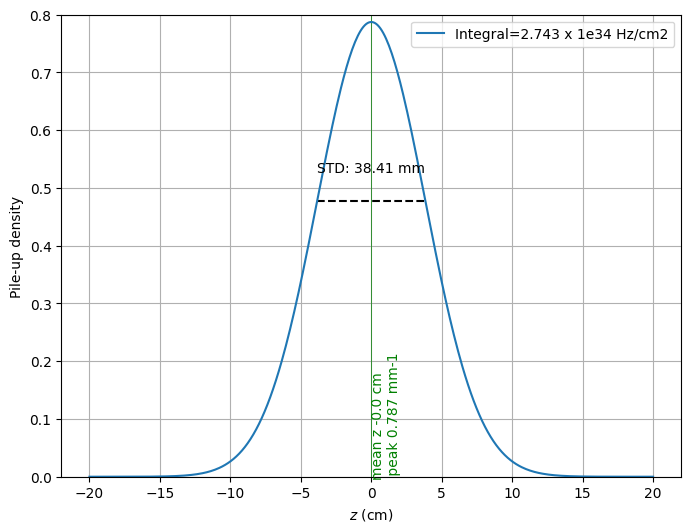

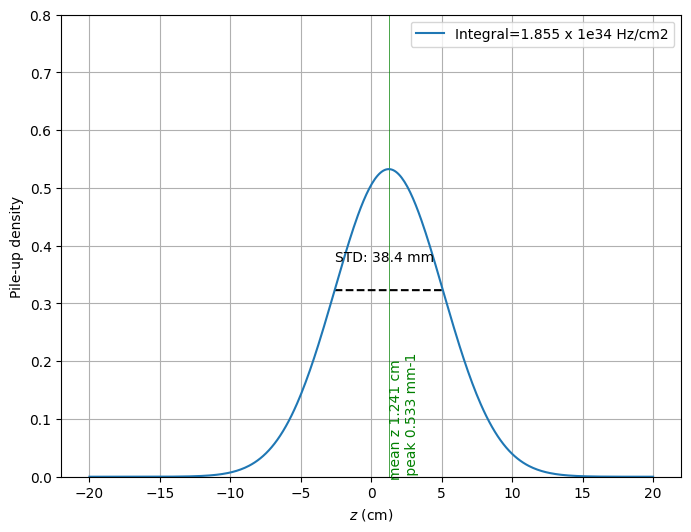

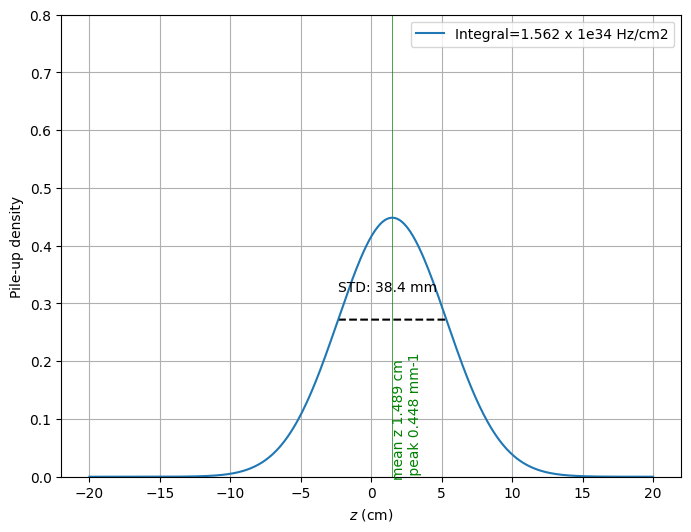

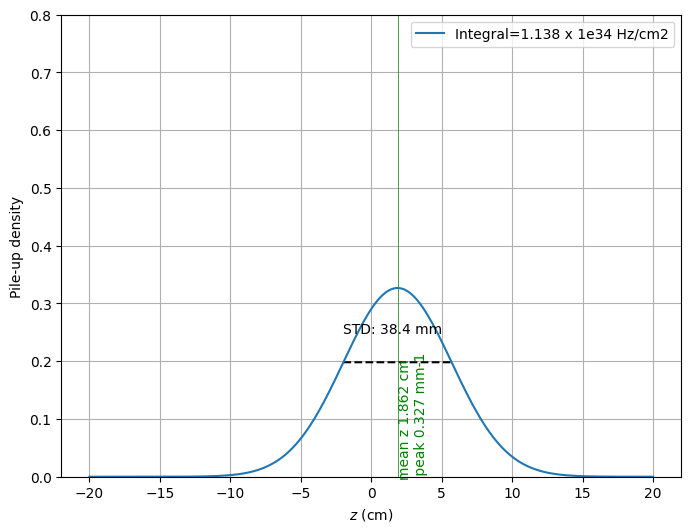

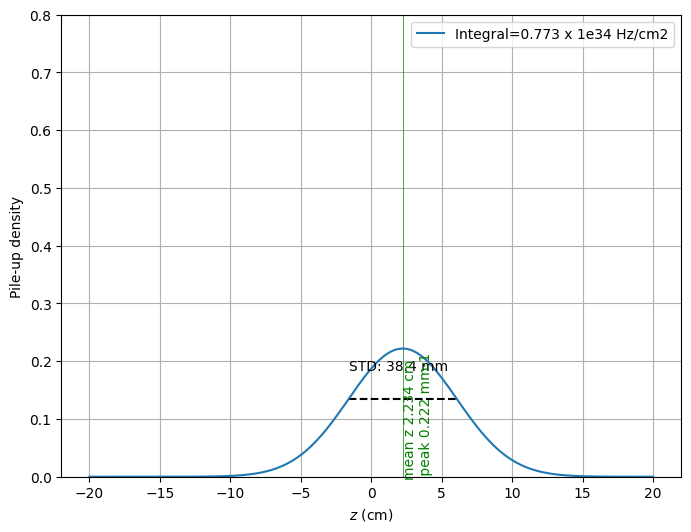

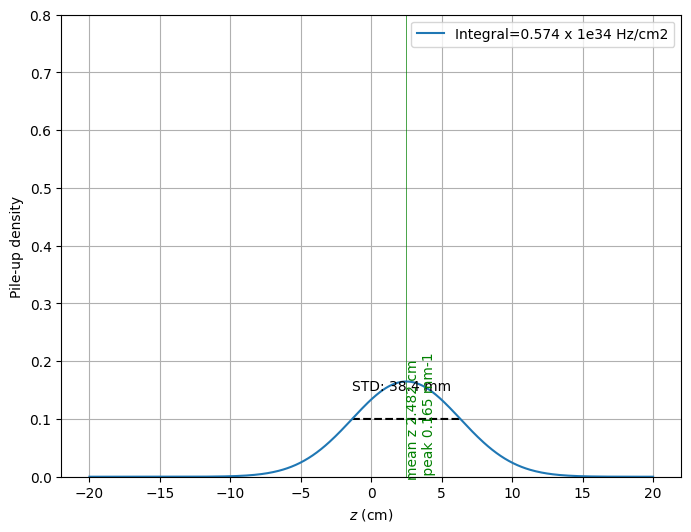

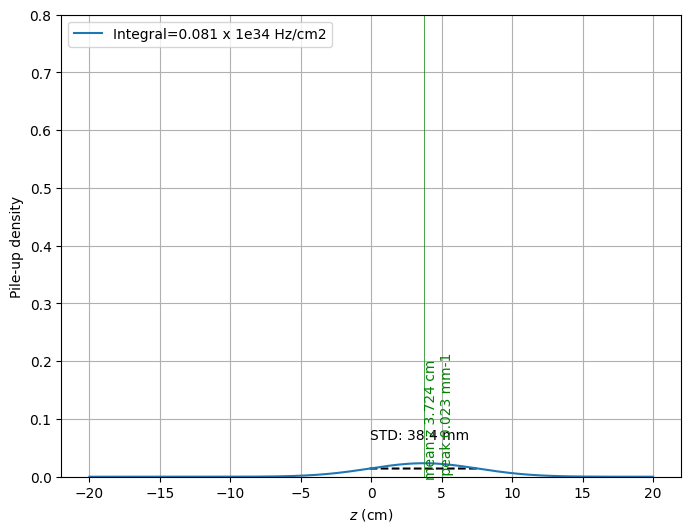

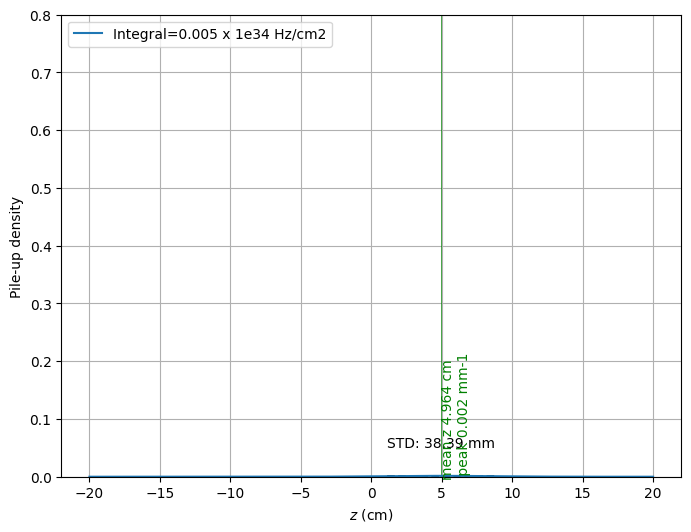

In [14]:


frev = 11245.5
nb = 2574
sigmainel = 8.0e-30
betx = 0.5
bety = 1.5
xing_x = 135
xing_y = 170

theta_crossing = np.arctan(170/135)
print("Crossing plane (deg): ", round(np.rad2deg(theta_crossing),3))

separation_plane = theta_crossing + np.deg2rad(90) #+ np.deg2rad(61.22) # np.pi/2.
print("Separation plane (deg): ", round(np.rad2deg(separation_plane),3))
print("Angle between crossing and separation (deg)", round(np.rad2deg(separation_plane),3) - round(np.rad2deg(theta_crossing),3))

for total_separation in [0, 1e-5, 1.2e-5, 1.5e-5, 1.8e-5, 2e-5, 3e-5 , 4e-5]:
    
    num_values = {
        x_1: total_separation*np.cos(separation_plane),
        px_1: xing_x*1e-6,
        y_1: total_separation*np.sin(separation_plane),
        py_1: xing_y*1e-6,
        sigmax: np.sqrt(2.5e-6/(7000.0/0.938) * betx),
        sigmay: np.sqrt(2.5e-6/(7000.0/0.938) * bety),
        sigma_inel:sigmainel,
        N:2.2e11,
        sigmaz:0.0761
    }
    
    pile_up_density_numeric = pile_up_density.subs(num_values)
    
    
    z_vals = np.linspace(-20e-2, 20e-2, 400)
    pile_up_density_vals = 1e-3*np.array([pile_up_density_numeric.subs(z, val).evalf() for val in z_vals])
    pile_up_density_vals = [float(i) for i in pile_up_density_vals]
    
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    plt.xlabel('$z$ (cm)')
    plt.ylabel('Pile-up density')
    
    normalize_pu =  np.trapz(pile_up_density_vals, z_vals)
    total_lumi = float(normalize_pu*1e3 * (frev * nb/sigmainel))
    
    mean_z = np.trapz(z_vals * pile_up_density_vals, z_vals) /normalize_pu
    rms = np.sqrt(np.trapz(z_vals**2 * pile_up_density_vals, z_vals) / normalize_pu)
    variance = np.trapz((z_vals - mean_z)**2 * pile_up_density_vals, z_vals) / normalize_pu
    std_dev = np.sqrt(variance)
    peak_pileup_density = np.max(pile_up_density_vals)
    
    
    from scipy.interpolate import interp1d
    interpolator = interp1d(z_vals, np.array(pile_up_density_vals), kind='linear', fill_value='extrapolate')
    y_std_dev_left = interpolator(mean_z - std_dev)
    y_std_dev_right = interpolator(mean_z + std_dev)
    
    plt.plot([(mean_z-std_dev)*1e2, (mean_z + std_dev)*1e2], [y_std_dev_left, y_std_dev_right], c="k", linestyle='--' )
    plt.text((mean_z-std_dev)*1e2 , y_std_dev_left + 0.05, (f"STD: {round(std_dev*1e3, 2)} mm") )
    
    plt.axvline(mean_z*1e2, c="g", lw=0.5)
    plt.text(mean_z*1e2, 0, f"mean z {round(mean_z*1e2,3)} cm \n peak {round(peak_pileup_density,3)} mm-1", rotation=90, c="g")
    
    plt.plot(z_vals*1e2, pile_up_density_vals, label=f'Integral={round(total_lumi/1e38, 3)} x 1e34 Hz/cm2')
    plt.legend()
    plt.ylim(0, 0.8)
    plt.grid(True)
    plt.show()
    
